<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />


# Worksheet 6.0 Clustering - Answers

This worksheet covers concepts relating to Unsupervised Learning.  It should take no more than 20-30 minutes to complete.  Please raise your hand if you get stuck.  

There are many ways to accomplish the tasks that you are presented with, however you will find that by using the techniques covered in class, the exercises should be relatively simple. 

## Import the Libraries
For this exercise, we will be using:
* Pandas (http://pandas.pydata.org/pandas-docs/stable/)
* Numpy (https://docs.scipy.org/doc/numpy/reference/)
* Matplotlib (http://matplotlib.org/api/pyplot_api.html)


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.spatial.distance import cdist
style.use("ggplot")
%matplotlib inline

# K-Means Clustering
In this example notebook, you will see how to implement K-Means Clustering in Python using Scikit-Learn and Pandas. 
Adapted from https://pythonprogramming.net/flat-clustering-machine-learning-python-scikit-learn/

## Step 1:  Get Data:
The first step is to prepare or generate the data.  In this dataset, the observations only have two features, but K-Means can be used with any number of features.  Since this is an unsupervised example, it is not necessary to have a "target" column.

In [2]:
data = pd.DataFrame([[1, 2],
              [5, 8],
              [1.5, 1.8],
              [8, 8],
              [1, 0.6],
              [9, 11]], columns=['x','y'])
print( data )

     x     y
0  1.0   2.0
1  5.0   8.0
2  1.5   1.8
3  8.0   8.0
4  1.0   0.6
5  9.0  11.0


## Step 2:  Build the Model:
Much like the supervised models, you first create the model then call the `.fit()` method using your data source.  The model is now populated with both your centroids and labels.  These can be accessed via the `.cluster_centers_` and `labels_` properties respectively.

You can view the complete documentation here: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

K-Means also has a `.predict()` method which can be used to predict the label for an observation.

In [3]:
kmeans = KMeans(n_clusters=2).fit(data)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(centroids)
print(labels)

[[1.16666667 1.46666667]
 [7.33333333 9.        ]]
[0 1 0 1 0 1]


In [4]:
test = pd.DataFrame([[4,2]])

kmeans.predict(test)
print(test)

   0  1
0  4  2


/Users/cgivre/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


# Visualizing the Clusters
The code below visualizes the clusters.  

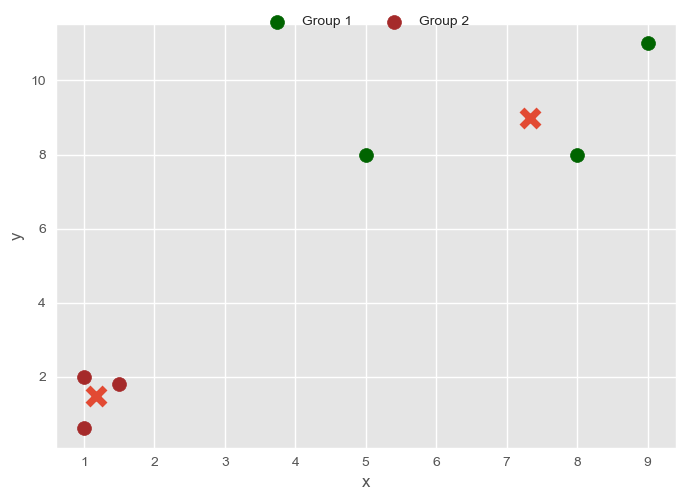

In [5]:
data['labels'] = labels

#plt.plot(data, colors[data['labels'], markersize = 10)

group1 = data[data['labels']==1].plot( kind='scatter', x='x', y='y',  s=100, color='DarkGreen', label="Group 1" )
group2 = data[data['labels']==0].plot( kind='scatter', x='x', y='y', s=100,color='Brown', ax=group1, label="Group 2" )
group1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)

plt.show()

# Clustering with Real Data
Now that you've tried K-means on some generated data, let's try it on some real data and see what we can produce. As before the first step is to read in the data into a DataFrame.  

We will be using this data later, but the dataset consists of approximately 6000 domains--5000 of which were generated by various botnets and 1000 are from the Alexa 1 Million.  The columns are:

* `dsrc`:  The source of the domain
* `domain`:  The actual domain
* `length`:  The length of the domain
* `dicts`:  Percentage containing dictionary words
* `entropy`:  The entropy of the domain
* `numbers`:  The number of digits in the domain
* `ngram`:  Different n-grams which appear in the domain (?)

In [7]:
data = pd.read_csv('../data/dga-full.csv')
data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram
49941,alexa,pro-tv,6,0.5,2.584963,0,3.382377
35332,nivdort,dutyshown,9,1.0,3.169925,0,7.284858
41469,nivdort,arivelight,10,1.0,3.121928,0,14.773868
48128,alexa,parwise,7,1.0,2.807355,0,4.379668
20791,gameoverdga,1qjx5qth9s6qhc1xjo4b82ph0,25,0.0,4.023465,9,0.000000


In [8]:
data['dsrc'].value_counts()

cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: dsrc, dtype: int64

## Scaling the Data
Since clustering relies on measuring distances between objects it is important that all data points be on the same scale.  There are various methods for doing this, which are beyond the scope of this class, however, for this example, we will use scikit-learn's `StandardScaler` to accomplish this.  (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

The StandardScaler transforms each column by:
* Subtracting from the element in each row the mean for each feature (column) and then taking this value and
* Dividing by that feature's (column's) standard deviation.

Scikit-learn has a transformer interface which is very similar to the other scikit-learn interfaces.  The basic steps are:
1.  Create the Scaler object
2.  Using the feature matrix, call the `.fit()` method to "train" the Scaler
3.  Use the `.transform()` method to scale the data.

**NOTE**: When using a Scaler, it is important to train the scaler on your data, and use this trained scalers on any future predictions. 

In [9]:
feature_columns = ['length', 'dicts','entropy','numbers','ngram']
scaled_feature_columns = ['scaled_length', 'scaled_dicts','scaled_entropy','scaled_numbers','scaled_ngram']

In [10]:
#Step 1:  Create the scaler
scaler = StandardScaler()

#Steps 2 & 3:  Fit the scaler and transform this data
scaled_df = scaler.fit_transform(data[feature_columns])

#Put the scaled data into a dataframe
scaled_df = pd.DataFrame(scaled_df, columns=scaled_feature_columns)

Take a look at the data and you'll see that the data is now all scaled consistently. 

In [11]:
scaled_df.sample(10)

,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
30306,-0.933453,-0.229954,-1.427975,-0.498385,-0.624587
23594,-0.933453,-0.573642,-0.402714,-0.498385,-0.535302
32383,-1.064714,-1.604706,-1.227875,-0.498385,-0.699054
29584,-0.014622,0.228297,0.241666,-0.498385,-0.609769
36183,-0.933453,1.144799,-0.402714,-0.498385,0.527146
30008,-0.145884,0.359226,0.157669,-0.498385,-0.338959
22077,1.560515,-1.299205,0.636271,1.970035,-0.699054
5439,-0.145884,-0.033560,0.404095,-0.498385,-0.699054
41429,0.116639,1.144799,0.459777,-0.498385,3.245600
28250,-0.408407,0.457423,0.031342,-0.498385,0.258055


Finally for convenience, we're going to merge the scaled data with the non-scaled data.  

In [12]:
final_data = pd.merge( data, scaled_df, left_index=True, right_index=True)

In [13]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
45709,alexa,kyk,3,0.000000,0.918296,0,0.000000,-1.589760,-1.604706,-3.993614,-0.498385,-0.811719
50043,alexa,maghreb24tv,11,0.636364,3.459432,2,2.845098,-0.539668,0.144979,0.389797,-0.118628,-0.279309
27968,necurs,rvwllxggbrtwcchgvfpn,20,0.450000,3.584184,0,0.000000,0.641685,-0.367429,0.604992,-0.498385,-0.811719
47913,alexa,tu-berlin,9,0.666667,3.169925,0,6.287891,-0.802191,0.228297,-0.109596,-0.498385,0.364949
17679,gameoverdga,172zulu1rh3enlcrmlpf16jp0oy,27,0.444444,4.180451,8,1.322219,1.560515,-0.382704,1.633543,1.020643,-0.564289


### Your Turn!
Now that we have data that is suitable (maybe) for clustering, in the section below, perform K-Means clustering on this data set.  Initially, start out with 2 clusters and assign the `cluster id` as a column in your DataFrame.

Then do a `value_counts()` on the `dsrc` column for each cluster to see how the model divided the data.  Try various values for `k` to see how it performed.

Remember to use the **scaled features** for your clustering.  

In [14]:
## Your code here...

kmeans = KMeans(n_clusters=2).fit(final_data[scaled_feature_columns])

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(centroids)
print(labels)

[[-0.49760996  0.3716326  -0.3885456  -0.4893535   0.20109624]
 [ 1.56899145 -1.17177795  1.22510555  1.5429584  -0.63406745]]
[1 1 1 ... 0 0 0]


In [15]:
final_data['dsrc'].value_counts()

cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: dsrc, dtype: int64

In [16]:
final_data['cluster_id'] = kmeans.labels_

In [18]:
final_data['cluster_id'].value_counts()

0    39842
1    12636
Name: cluster_id, dtype: int64

In [25]:
final_data[final_data['cluster_id'] == 1]['dsrc'].value_counts()

gameoverdga    9993
bamital        2500
necurs          140
alexa             3
Name: dsrc, dtype: int64

In [24]:
final_data[final_data['cluster_id'] == 0]['domain'].sample(5)

30246      smgmkaycqy
10718    yneehudaphxq
47999       joycasino
36527        meatkind
25364        lekqljsx
Name: domain, dtype: object

In [24]:
final_data['domain'][final_data['dsrc'] == 'cryptolocker'].sample(5)

12137     vyhrysjqfnujcx
10214     jeorpwrrldypfo
8861        xpfiamqibywo
3246     aqxesbvejqssleq
4597       ugaeihhxfgcec
Name: domain, dtype: object

In [22]:
final_data[final_data['dsrc'] == "bamital"]['domain'].sample(10)

391     dce6735a774f1e65ff4f922aa47076fe
540     580c37c76fba54c23b4f7efd6ed7a7d0
25      4a133624d27fc1990e0d1718cfb50ec5
1264    f896bef76490cf27eb5ce9dcc8ff5dc7
1714    e1be5068b1e32159e7fba02360d130d3
1211    1efbd5c33168bc407e02760b40c7eed7
1969    99404b0dc62222b4c1b0a40578213eb6
1816    305e6f636225859f33e0b6703807ca0f
1837    65b525dd8e4cd6c7c1fcbca153041b9c
400     427b2f9201fb05a8fbad560576ce047b
Name: domain, dtype: object

In [20]:
final_data[final_data['dsrc'] == "nivdort"]['domain'].sample(10)

42159      deadhand
40008     songwhere
34975      hangrain
37684      thisname
37080      jumpopen
40963     pickcould
41794     whichaunt
42214     wishsince
33581     watchfeed
39329    sundayride
Name: domain, dtype: object

In [21]:
final_data[(final_data['cluster_id'] == 1) & (final_data['dsrc'] == 'necurs')]['domain']

22500       aqpoesogafvwyvlog
22501                 iwxdakv
22502            qwotyugasduc
22503          fywbpebyvhgbov
22504          lwmgjqvhpwiabx
                 ...         
32495                chdxyfak
32496             upgclshimcu
32497                ygtwdecs
32498    jcbwowxlmhpawfuwfjyn
32499                 vpvlyut
Name: domain, Length: 9860, dtype: object

In [22]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram,cluster_id
15754,gameoverdga,9eoyb91e1cbf6d0yv151w7lp7u,26,0.000000,4.008132,11,0.000000,1.429253,-1.604706,1.336295,1.590278,-0.811719,0
42197,nivdort,frontsince,10,1.000000,3.121928,0,13.903036,-0.670930,1.144799,-0.192390,-0.498385,1.789988,1
49084,alexa,identityguard,13,1.000000,3.238901,0,16.569908,-0.277145,1.144799,0.009387,-0.498385,2.289046,1
232,bamital,0da46c065088768316c51d6a98d816e9,32,0.000000,3.456748,24,0.000000,2.216822,-1.604706,0.385167,4.058697,-0.811719,0
26802,necurs,eiwerppfqgoksam,15,0.666667,3.640224,0,4.698275,-0.014622,0.228297,0.701661,-0.498385,0.067480,1


## Food for thought:
Now that you've done clustering with various numbers of clusters, it appears that the data acutally does break evenly into 2 clusters.  Take a look at the original data and see if you can come up with a reason why that is the case.

## Visualizing Performance
As we already know, it is difficult to measure the performance of clustering models since there usually is no known ground truth from which to evaluate your model.  However, there are two techniques which 

The K-Elbow Visualizer implements the “elbow” method of selecting the optimal number of clusters for K-means clustering. K-means is a simple unsupervised machine learning algorithm that groups data into a specified number (k) of clusters. Because the user must specify in advance what k to choose, the algorithm is somewhat naive – it assigns all members to k clusters even if that is not the right k for the dataset.

The elbow method runs k-means clustering on the dataset for a range of values for k (say from 1-10) and then for each value of k computes an average score for all clusters. By default, the distortion_score is computed, the sum of square distances from each point to its assigned center. Other metrics can also be used such as the silhouette_score, the mean silhouette coefficient for all samples or the calinski_harabaz_score, which computes the ratio of dispersion between and within clusters.

When these overall metrics for each model are plotted, it is possible to visually determine the best value for K. If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is the best value of k. The “arm” can be either up or down, but if there is a strong inflection point, it is a good indication that the underlying model fits best at that point. (http://www.scikit-yb.org/en/latest/api/cluster/elbow.html)

In python there is a module called `YellowBrick` which facilitates visualizing the K-Elbow score.  All of YellowBrick's visualizations follow essentually the same pattern:

1.  Create the Visualizer Object
2.  Call the `.fit()` method using the data
3.  Call the `.poof()` method to render the visualization

The snippet below demonstrates how to use the elbow method to visualize the clustering model's performance on this dataset.
```python
visualizer = KElbowVisualizer(KMeans(), k=(4,12))

visualizer.fit( feature_matrix ) 
visualizer.poof()
```

### Your Turn!
In the box below, create a visualization using the elbow method to see if there are any inflection points in the distortion score.

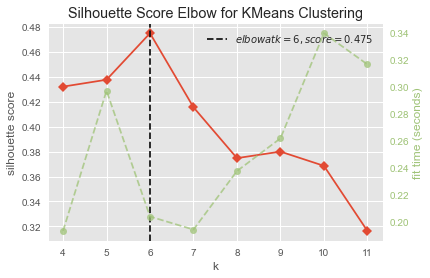

In [23]:
# Your code here...
visualizer = KElbowVisualizer( KMeans(), k=(4,12), metric='silhouette')

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.show()

## Another Way to Visualize Clustering Performance
The Silhouette Coefficient is used when the ground-truth about the dataset is unknown and computes the density of clusters computed by the model. The score is computed by averaging the silhouette coefficient for each sample, computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. This produces a score between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering. (http://www.scikit-yb.org/en/latest/api/cluster/silhouette.html)


### Your Turn!
Using the YellowBrick `SilhouetteVisualizer`, try visualizing models with various values of `K`.

**Note**:  This visualization is quite expensive, so I recommend performing this using a sample o your original data.

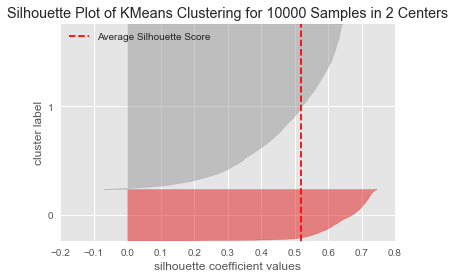

In [24]:
# Your code here...
visualizer = SilhouetteVisualizer( KMeans(n_clusters=2))

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.show()

## DBSCAN
Now that you've tried K-Means, let's try doing some clustering using DBSCAN (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).  Remember that the main tuning parameters for DBSCAN are:

* **epsilon (eps)**:  The minimum distance between two samples 
* **min_samples**:  The minimum number of samples needed to form a neighborhood

By default epsilon is 0.5 and the min_samples is 5. First, try DBSCAN with the default options.  If you use the `fit_predict()` function, you can save the results in a new column in your data.  

How did this compare with K-Means?  Given that you actually know what the data really is, how did DBSCAN do in terms of identifing meaningful clusters?  Look at the `dsrc` column and do `value_counts()` for the various neighhborhoods.  What did you notice?

Try again, but this time experiment with the values of epsilon and min_samples and see what DBSCAN comes up with. 

In [26]:
dbscan = DBSCAN(min_samples=50)

In [27]:
final_data['dbs_default'] = dbscan.fit_predict(final_data[scaled_feature_columns])

In [28]:
final_data['dbs_default'].value_counts()

 1    39301
 2     9973
 0     2500
-1      284
 4      259
 3      116
 5       45
Name: dbs_default, dtype: int64

In [30]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: dsrc, dtype: int64

In [33]:
final_data[final_data['dbs_default'] == 1 ][['dsrc','domain']].sample(10)

,dsrc,domain
7694,cryptolocker,hiogbwihymnvx
3940,cryptolocker,iwqxswfdbslu
33448,nivdort,visitouter
31827,necurs,uuodxyekdlcakcwfr
30623,necurs,iocgirsmhfj
11294,cryptolocker,sakpkiokwckprg
9340,cryptolocker,iujyixokiwwiwf
11902,cryptolocker,lvcdhdsatlitn
2708,cryptolocker,rxqntusvfhsry
45772,alexa,hankyu


In [29]:
final_data[final_data['dbs_default'] == -1 ]['dsrc'].sample(10)

44256          alexa
52147          alexa
47007          alexa
48689          alexa
50233          alexa
46638          alexa
50159          alexa
45624          alexa
49991          alexa
16105    gameoverdga
Name: dsrc, dtype: object

In [30]:
final_data['domain'][final_data['dsrc'] == "nivdort"].sample(5)

41831     spokedont
37995     deadseven
34792      wishback
37773    wentaugust
34707    frontbelow
Name: domain, dtype: object

In [31]:
final_data[final_data['dbs_default'] == 2 ]['dsrc'].value_counts()

gameoverdga    9973
Name: dsrc, dtype: int64

In [32]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: dsrc, dtype: int64

In [33]:
final_data[final_data['dsrc'] == "cryptolocker"]['domain'].sample(10)

7840        anmkkwdwkbih
10693       uyrheeekbtlf
2647       fqfymnbofsisw
5349      sshtidiwrsvdjf
8822        ayirbvukogpc
10553       kknpqpwuadsp
10283     ayoqsyliwlxxyi
11482    yhumcgqmqfunvxm
9614        hkjlhqmscshp
9885       ghtvthxssuyft
Name: domain, dtype: object

In [34]:
final_data[final_data['dsrc'] == "necurs"]['domain'].sample(10)

29766            qioeeyqsiktbp
28356               ojuikitbde
25770    hbllxhcsuqahbrgqaklvv
32162    pogaqaholvqwiftgxlkwx
27290         owqgjbbggfgbxxvw
29127         eenhauhwdfaghgbb
29003     uvuhfalslxumlnrgykge
22728      fwrnwglywteekyuwhyp
22930                 igambhub
29661         sjnddpwbdkpvftma
Name: domain, dtype: object